# Load py_ballisticcalc and set units

In [1]:
from typing_extensions import Union
from py_ballisticcalc import (DragModel, TableG1, Distance, Weight, Ammo, Velocity, Weapon, Shot, Atmo, Vacuum, Wind,
                              Angular, Calculator, RangeError, HitResult, logger, InterfaceConfigDict, PreferredUnits)
from py_ballisticcalc.unit import *
PreferredUnits.distance = Unit.Meter
PreferredUnits.velocity = Unit.MPS
PreferredUnits.drop = Unit.Meter

C:\Users\Sergey\PycharmProjects\py-ballisticcalc\py_ballisticcalc\__init__.py:46: UserWarning: Library running in pure python mode. For better performance install 'py_ballisticcalc.exts' binary package
  warnings.warn("Library running in pure python mode. "


## Wrapper function to handle extreme scenarios

In [2]:
def must_fire(interface: Calculator, zero_shot, trajectory_range, extra_data, time_step,
              **kwargs) -> tuple[HitResult, Union[RangeError, None]]:
    try:
        return interface.fire(zero_shot, trajectory_range, **kwargs, extra_data=extra_data, time_step=time_step), None
    except RangeError as err:
        # Create HitResult with data that were calculated before trajectory exception reached
        return HitResult(zero_shot, err.incomplete_trajectory, extra=extra_data), err

# Ex.1: Shot hits minimum altitude before end of range

Using a projectile with a very low BC (meaning not very aerodynamic).  We simulate a shot starting at altitude of 1000m above ground level and ask for trajectory going 1000m downrange.  Simulation reports it hitting ground level before it can travel 1000m horizontally.

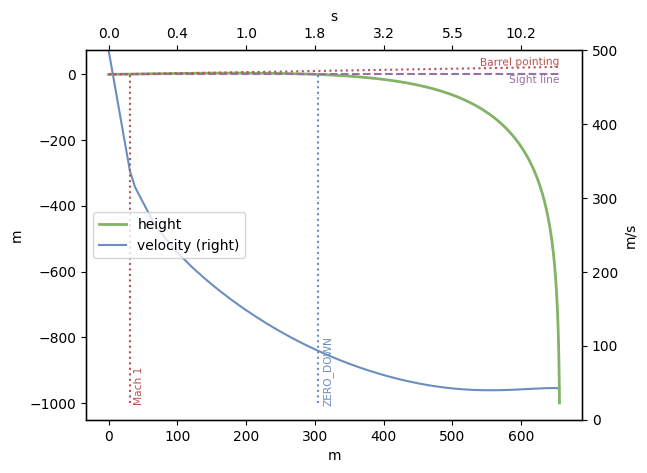

In [3]:
drag_model = DragModel(bc=0.03, drag_table=TableG1)  # Projectile has G1 BC of 0.03
zero = Shot(weapon=Weapon(),
            ammo=Ammo(drag_model, Velocity.MPS(500)),  # Muzzle velocity is 500m/s
            atmo=Atmo(altitude=Distance.Meter(1000)),  # Shot is fired at an altitude of 1000m ASL
            relative_angle=Angular.Degree(2.0)  # Point barrel 2° above horizon
            )

calc = Calculator(config={
    "cMinimumVelocity": 0,  # Run simulation as long as velocity is non-zero
    "cMinimumAltitude": 0,  # Stop simulation at sea level
})

# Compute trajectory out to horizontal range of 1000m
hit_result, err = must_fire(calc, zero, Distance.Meter(1000), extra_data=True, time_step=0.1)

if err:
    logger.warning("%s, trajectory incomplete", err)

# Plot trajectory
from py_ballisticcalc.visualize.plot import show_hit_result_plot
#matplotlib.use('TkAgg')
p = hit_result.plot()
show_hit_result_plot()

## Inspect data
We can see that shot begins pointing 2° above horizon, but after 28 seconds and 655m travel downrange it has almost no forward velocity.  Instead it has reached its terminal velocity of 42m/s and is falling almost vertically.

In [4]:
df = hit_result.dataframe(True).drop(['target_drop', 'drop_adj', 'windage', 'windage_adj', 'look_distance', 'density_factor', 'energy', 'ogw', 'flag'], axis=1).set_index('distance')
#df.to_clipboard()
display(df.head(3))
display(df.tail(3))

,time,velocity,mach,height,angle,drag
distance,,,,,,
0.0 m,0.000 s,500 m/s,1.49 mach,-0.0 m,2.0000 °,0.000
31.0 m,0.077 s,336 m/s,1.00 mach,1.1 m,1.8914 °,3.354
38.6 m,0.100 s,314 m/s,0.93 mach,1.3 m,1.8512 °,2.523


,time,velocity,mach,height,angle,drag
distance,,,,,,
655.5 m,28.335 s,42 m/s,0.12 mach,-992.5 m,-89.7377 °,0.235
655.5 m,28.436 s,42 m/s,0.12 mach,-996.8 m,-89.7438 °,0.235
655.6 m,28.514 s,42 m/s,0.12 mach,-1000.1 m,-89.7484 °,0.235


# Ex.2: Dropped Projectile
Same projectile, dropped from an altitude of 1000m

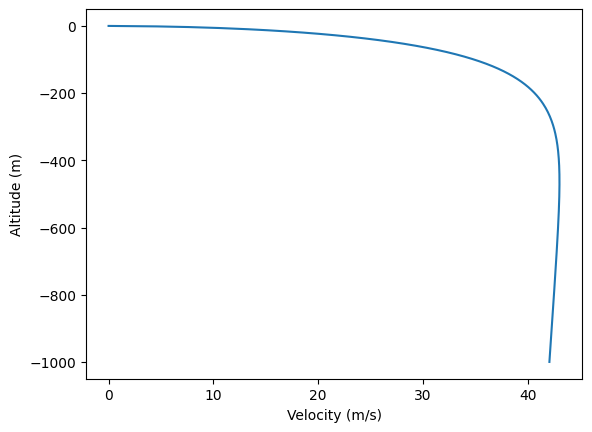

In [5]:
zero = Shot(weapon=Weapon(),
            ammo=Ammo(drag_model, Velocity.MPS(0)),  # Projectile starts with no velocity
            atmo=Atmo(altitude=Distance.Meter(1000)),  # Projectile dropped from an altitude of 1000m ASL
            )

hit_result, err = must_fire(calc, zero, Distance.Meter(1000), extra_data=True, time_step=0.1)
if err:
    logger.warning("%s, trajectory incomplete", err)

drop_df = hit_result.dataframe()
ax = drop_df.plot(x='velocity', y='height', xlabel='Velocity (m/s)', ylabel='Altitude (m)', legend=False)

## Inspect data
Maximum velocity of 43m/s is achieved after falling 463.9m.  Thereafter the terminal velocity decreases to 42m/s as the projectile encounters increasingly dense atmosphere.

In [6]:
df = hit_result.dataframe(True).drop(['distance', 'target_drop', 'drop_adj', 'windage', 'windage_adj', 'look_distance', 'energy', 'ogw', 'flag'], axis=1)
#df.to_clipboard()
max_velocity_row = drop_df[drop_df.velocity == drop_df.velocity.max()].index[0]
display(df[df.index == max_velocity_row])
df.tail(1)

,time,velocity,mach,height,angle,density_factor,drag
134,13.744 s,43 m/s,0.13 mach,-464.0 m,-90.0000 °,-5.044e-02,0.228


,time,velocity,mach,height,angle,density_factor,drag
259,26.325 s,42 m/s,0.12 mach,-1000.0 m,-90.0000 °,1.867e-05,0.235


# Ex.3: Plunging Fire
Same blunt projectile is fired at an elevation of 87° – nearly straight upwards.  So it will reach an apex and then fall back to ground.

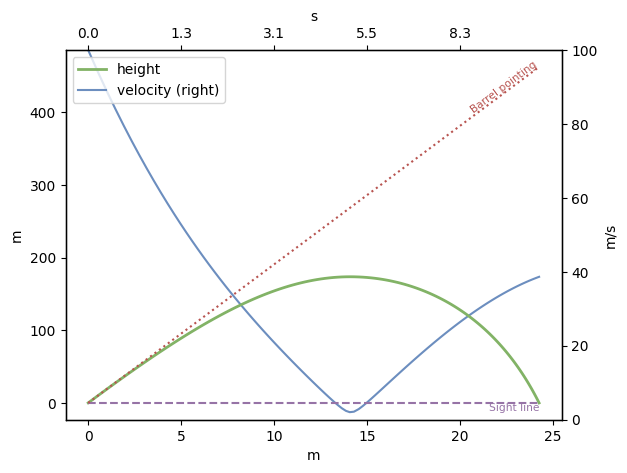

In [7]:
zero = Shot(weapon=Weapon(),
            ammo=Ammo(drag_model, Velocity.MPS(100)),
            relative_angle=Angular.Degree(87.0))

hit_result, err = must_fire(calc, zero, Distance.Meter(1000), extra_data=True, time_step=0.1)
if err:
    logger.warning("%s, trajectory incomplete", err)

p = hit_result.plot()
show_hit_result_plot()

## Apex data
Looking for the maximum observed height, we find the apex reached 5.025s after launch at a horizontal distance of 14.1m.

In [8]:
traj_df = hit_result.dataframe()
apex_row = traj_df[traj_df.height == traj_df.height.max()].index[0]

df = hit_result.dataframe(True).drop(['target_drop', 'drop_adj', 'windage', 'windage_adj', 'look_distance', 'density_factor', 'energy', 'ogw', 'flag'], axis=1)
df.loc[apex_row-1:apex_row+1]

,time,distance,velocity,mach,height,angle,drag
48,4.924 s,13.9 m,2 m/s,0.01 mach,173.6 m,32.5169 °,0.015
49,5.026 s,14.1 m,2 m/s,0.01 mach,173.7 m,8.2276 °,0.012
50,5.138 s,14.3 m,2 m/s,0.01 mach,173.7 m,-21.7517 °,0.012


# Ex.4: Strong-wind Reversing Trajectory
Here we loft the blunt projectile at 100m/s at a 70° elevation into a 20m/s headwind.  This windspeed blows the projectile backwards so that it impacts the ground behind the firing point.

C:\Users\Sergey\PycharmProjects\py-ballisticcalc\py_ballisticcalc\visualize\plot.py:220: UserWarning: The trajectory is backward bending. Please add custom time visualization if needed
  warnings.warn("The trajectory is backward bending. Please add custom time visualization if needed")


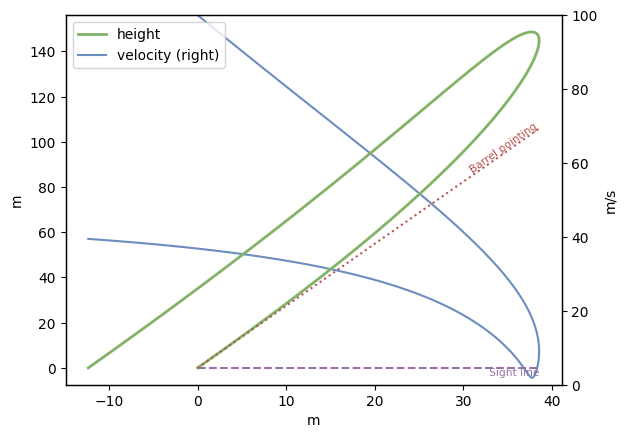

,distance,velocity,mach,height,angle,drag
time,,,,,,
10.636 s,-7.7 m,39 m/s,0.11 mach,12.9 m,-109.5082 °,0.209
10.736 s,-9.0 m,39 m/s,0.11 mach,9.2 m,-109.6070 °,0.210
10.838 s,-10.4 m,39 m/s,0.11 mach,5.5 m,-109.7073 °,0.211
10.940 s,-11.7 m,39 m/s,0.12 mach,1.7 m,-109.8064 °,0.212
10.986 s,-12.3 m,39 m/s,0.12 mach,-0.0 m,-109.8516 °,0.212


In [9]:
zero = Shot(weapon=Weapon(),
            ammo=Ammo(drag_model, Velocity.MPS(100)),
            relative_angle=Angular.Degree(70.0))
zero.winds = [Wind(Velocity.MPS(20), Angular.OClock(6))]

hit_result, err = must_fire(calc, zero, Distance.Meter(1000), extra_data=True, time_step=0.1)
if err:
    logger.warning("%s, trajectory incomplete", err)

p = hit_result.plot()
show_hit_result_plot()

df = hit_result.dataframe(True).drop(['target_drop', 'drop_adj', 'windage', 'windage_adj', 'look_distance', 'density_factor', 'energy', 'ogw', 'flag'], axis=1).set_index('time')
df.to_clipboard()
df.tail()

# Ex.5: Vacuum Trajectory

In [10]:
# In vacuum we have analytic solutions to trajectory:
# Time to return to ground level t = 2 * v_0 * sin(theta) / gravity
# Horizontal distance x = t * v_0 * cos(theta)
import math
PreferredUnits.distance = Unit.Foot
PreferredUnits.velocity = Unit.FPS
PreferredUnits.drop = Unit.Foot

launch_angle = Angular.Degree(30)
v_0 = -10 * calc._engine_instance.gravity_vector.y
weapon = Weapon(zero_elevation=launch_angle)
shot_info = Shot(weapon=weapon, ammo=Ammo(DragModel(1, TableG1), Velocity.FPS(v_0)), atmo=Vacuum())
t = -2 * v_0 * math.sin(launch_angle >> Angular.Radian) / calc._engine_instance.gravity_vector.y
x = v_0 * t * math.cos(launch_angle >> Angular.Radian)
calc = Calculator(config=InterfaceConfigDict(cMinimumVelocity=0))
data = calc.fire(shot_info, Distance.Foot(x), Distance.Foot(x/10.0))
print(f"In a vacuum, projectile returns to ground after {t}s at a distance of {x} ft")
data.dataframe(True).drop(['energy', 'ogw', 'flag', 'windage', 'windage_adj', 'density_factor'], axis=1).set_index('distance')

In a vacuum, projectile returns to ground after 9.999999999999998s at a distance of 2786.3544642630713 ft


,time,velocity,mach,height,target_drop,drop_adj,look_distance,angle,drag
distance,,,,,,,,,
0.00 ft,0.000 s,321.7 ft/s,0.29 mach,-0.00 ft,-0.00 ft,0.000 mil,0.00 ft,30.0000 °,0.000
278.64 ft,1.000 s,306.9 ft/s,0.28 mach,144.77 ft,144.77 ft,488.089 mil,278.64 ft,24.7913 °,0.000
557.27 ft,2.000 s,294.9 ft/s,0.26 mach,257.37 ft,257.37 ft,440.694 mil,557.27 ft,19.1066 °,0.000
835.91 ft,3.000 s,286.0 ft/s,0.26 mach,337.79 ft,337.79 ft,391.173 mil,835.91 ft,13.0039 °,0.000
1114.54 ft,4.000 s,280.5 ft/s,0.25 mach,386.03 ft,386.03 ft,339.629 mil,1114.54 ft,6.5868 °,0.000
1393.18 ft,5.000 s,278.6 ft/s,0.25 mach,402.11 ft,402.11 ft,286.213 mil,1393.18 ft,-0.0000 °,0.000
1671.81 ft,6.000 s,280.5 ft/s,0.25 mach,386.01 ft,386.01 ft,231.133 mil,1671.81 ft,-6.5868 °,0.000
1950.45 ft,7.000 s,286.0 ft/s,0.26 mach,337.73 ft,337.73 ft,174.643 mil,1950.45 ft,-13.0039 °,0.000
2229.08 ft,8.000 s,294.9 ft/s,0.26 mach,257.28 ft,257.28 ft,117.048 mil,2229.08 ft,-19.1066 °,0.000
